<a href="https://colab.research.google.com/github/Krankile/ensemble-forecasting/blob/main/ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#setup

In [ ]:
!pip install --upgrade statsmodels
!pip install pmdarima
!pip install tbats

In [ ]:
import statsmodels.api as sm
import pmdarima as pm #this is for AutoArima
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import pickle
from tbats import BATS, TBATS
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from math import sin
from math import pi
from statsmodels.tsa.forecasting.theta import ThetaModel 
from statsmodels.tsa.api import STLForecast
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg, ar_select_order


#Building an ensamble time series forecasting model

Create some test timeseries

In [ ]:
def time_series_creator(amount_of_series, max_length_of_time_series, random_noise):
  sin_lst = []
  linear_lst = []
  random_drift = []
  #log_curve = [] Possibly implement this later 


  for serie in range(int(1000/3)):
    single_sin = []
    single_linear = []
    single_random_drift = [0]


    linear_trend = 5*(1-2*random.random())
    length_of_timeseries = random.randint(10,max_length_of_time_series) 

    for t in range(length_of_timeseries):
      single_sin.append(sin(64*t/(pi*length_of_timeseries)) + 0.3*random_noise*2*(0.5-random.random()) )
      single_linear.append(linear_trend*t + 5*random_noise*2*(0.5-random.random()))
      single_random_drift.append(single_random_drift[-1]  + 2*(0.5-random.random()))
    
    sin_lst.append(single_sin)
    linear_lst.append(single_linear)
    random_drift.append(single_random_drift[1:])
  return sin_lst, linear_lst, random_drift

In [ ]:
amount_of_series = 1000
max_length_of_time_series = 250
random_noise = True 

sines, linear, random_drift = time_series_creator(amount_of_series, max_length_of_time_series,random_noise)

Visualise some series, good forcasting algorithms should be able to find trend in sines and linear series. f_1 = y_{t-1} should be best for random drift 

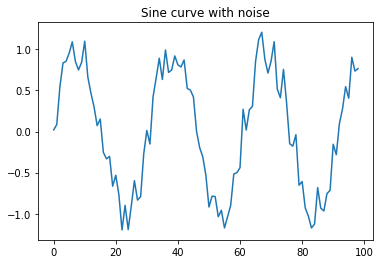

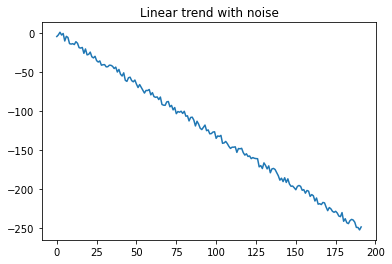

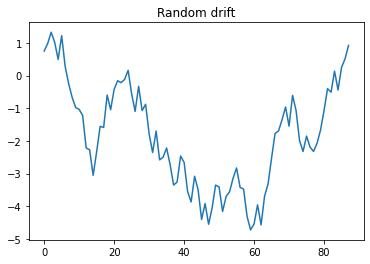

In [ ]:
#pick three random series and save index for later forcast

sine_example = sines[random.randint(1, len(sines) -1)]
linear_example = linear[random.randint(1, len(linear) -1)]
random_drift_example = random_drift[random.randint(1, len(random_drift) - 1)]
noise_string = " with noise" if random_noise == True else " without noise"
def plot_series(run):
  if run:
    plt.plot(sine_example)
    plt.title(f"Sine curve{noise_string}")
    plt.show()
    plt.plot(linear_example)
    plt.title(f"Linear trend{noise_string}")
    plt.show()
    plt.plot(random_drift_example)
    plt.title("Random drift")
    plt.show()

Implement models as in Montero-Manso et al. 

Start by implementing all models which already is part of stmodels 

1) Implement naive

Test:

In [ ]:
def naive(time_series, forecast_horizon=1):
  return [time_series[-1]]*forecast_horizon

Class:

In [ ]:
class Naive:
  
  def __init__(self):
    self.time_series = []
  
  def fit(self,time_series, seasonality=None):
    self.time_series = time_series

  def forecast(self, forecast_horizon=1):
    if self.time_series == []:
      raise Exception("Tried forecast without fitting")
    return [self.time_series[-1]]*forecast_horizon
  
  def __str__(self):
    return "Naive"

2) Implement random walk with drift 

Test:


In [ ]:
def random_walk_with_drift(time_series, forecast_horizon=1):
  ts = [i for i in range(len(time_series))]
  model = sm.OLS(np.array(time_series),np.array(ts))
  model = model.fit()
  trend = model.fittedvalues
  a = (trend[-1] - trend[0])/len(trend)

  sigma = np.std(np.array(time_series) - np.array([a*i for i in range(len(time_series))]) )
  y_t = [time_series[-1]]
  
  for t in range(forecast_horizon):
    y_t.append(y_t[-1] + a + np.random.normal(0, sigma))
  return y_t

Class:

In [ ]:
class Random_walk_with_drift:
  
  def __init__(self):
    self.time_series = []
  
  def fit(self,time_series, seasonality=None):
    self.time_series = time_series

  def forecast(self, forecast_horizon=1):
    ts = [i for i in range(len(self.time_series))]
    model = sm.OLS(np.array(self.time_series),np.array(ts))
    model = model.fit()
    trend = model.fittedvalues
    a = (trend[-1] - trend[0])/len(trend)

    sigma = np.std(np.array(self.time_series) - np.array([a*i for i in range(len(self.time_series))]) )
    y_t = [self.time_series[-1]]
    
    for t in range(forecast_horizon):
      y_t.append(y_t[-1] + a + np.random.normal(0, sigma))
    
    return y_t[1:]
  def __str__(self):
    return "Random walk with drift"


3) Implement seasonal naive

Code for seasonal naive, as its not a part of statmodels, author:   Author: Sandeep Pawar, collected 21.10.21
from: https://pawarbi.github.io/blog/forecasting/r/python/rpy2/altair/fbprophet/ensemble_forecast/uncertainty/simulation/2020/04/21/timeseries-part2.html#Seasonal-Naive


In [ ]:
def pysnaive(train_series,seasonal_periods,forecast_horizon):
    '''
    Python implementation of Seasonal Naive Forecast. 
    This should work similar to https://otexts.com/fpp2/simple-methods.html
    Returns two arrays
     > fitted: Values fitted to the training dataset
     > fcast: seasonal naive forecast
    
    Author: Sandeep Pawar
    
    Date: Apr 9, 2020
    
    Ver: 1.0
    
    train_series: Pandas Series
        Training Series to be used for forecasting. This should be a valid Pandas Series. 
        Length of the Training set should be greater than or equal to number of seasonal periods
        
    Seasonal_periods: int
        No of seasonal periods
        Yearly=1
        Quarterly=4
        Monthly=12
        Weekly=52
        

    Forecast_horizon: int
        Number of values to forecast into the future
    
    e.g. 
    fitted_values = pysnaive(train,12,12)[0]
    fcast_values = pysnaive(train,12,12)[1]
    '''
    
    if len(train_series)>= seasonal_periods: #checking if there are enough observations in the training data
        
        last_season=train_series.iloc[-seasonal_periods:]
        
        reps=np.int(np.ceil(forecast_horizon/seasonal_periods))
        
        fcarray=np.tile(last_season,reps)
        
        fcast=pd.Series(fcarray[:forecast_horizon])
        
        fitted = train_series.shift(seasonal_periods)
        
    else:
        fcast=print("Length of the trainining set must be greater than number of seasonal periods") 
    
    return fitted, fcast



Make a wrapper around pysnaive to handle input and output types

Test:

In [ ]:
def snaive(time_series,forecast_horizon=1, seasonality=None):
  if seasonality == None:
      seasonality = forecast_horizon
    # Add this inside list below to make forcast and seasonality fit+ (-time_series[-seasonality]+time_series[-1])
  return list(pysnaive(pd.Series(time_series),forecast_horizon,seasonality)[1]) 


Class:

In [ ]:
class Snaive:
  def __init__(self):
    self.time_series = []
  
  def fit(self, time_series, seasonality=None):
    self.time_series = time_series
    self.seasonality = None

  def forecast(self, forecast_horizon=1):
    if self.seasonality == None:
      self.seasonality = forecast_horizon
    # Add this inside list below to make forcast and seasonality fit+ (-time_series[-seasonality]+time_series[-1])
    return list(pysnaive(pd.Series(self.time_series),forecast_horizon, forecast_horizon)[1]) #TODO: last self.forecast_horizon is hardcoded like in FFORMA
  
  def __str__(self):
    return "Snaive"

4) Implement theta method

Test:

In [ ]:
def theta(time_series, seasonality=10, forecast_horizon=1):
    model = ThetaModel(np.array(time_series),period=seasonality)
    model = model.fit()
    return model.forecast(forecast_horizon, 2).tolist()

class:

In [ ]:
class Theta:   #https://www.rdocumentation.org/packages/forecast/versions/8.15/topics/findfrequency this model uses spectral decomposition and finds the maxima. Current theta implementation assumes many seasonalities. 
  def __init__(self):
    self.time_series = []
    self.model = ""
  
  def fit(self,time_series, seasonality=None):
    seasonality = 10
    self.time_series = time_series
    model = ThetaModel(np.array(time_series),period=seasonality)
    self.model = model.fit()

  def forecast(self, forecast_horizon=1):
    return self.model.forecast(forecast_horizon, 2).tolist()
  
  def __str__(self):
    return "Theta"

5) Implement AutoArima from pm

Test:

In [ ]:
def auto_arima(time_series, forecast_horizon):
  model = pm.auto_arima(time_series, stepwise=False).fit(time_series) #TODO: M4 #2 has approximation = False to improve runtimes. 
  return model.predict(forecast_horizon).tolist()

class:

In [ ]:
 class Auto_Arima:
  def __init__(self):
      self.time_series = []
      self.model = ""
  
  def fit(self,time_series, seasonality=None):
    self.time_series = time_series
    self.model = pm.auto_arima(time_series, stepwise=False).fit(time_series)

  def forecast(self, forecast_horizon=1):
    return self.model.predict(forecast_horizon).tolist()
  
  def __str__(self):
    return "Auto Arima"

6) Implement Exponential Smoothing

Test:

In [ ]:
def eps(time_series, forecasting_horizon): #This should be implemented as AutoEts later from the R package
  model = SimpleExpSmoothing(time_series)
  model_fit = model.fit()
  return list(model_fit.predict(len(time_series) - forecast_horizon))

#plt.(auto_eps(sine_example, 40))


class:

In [ ]:
class Eps: #This should be implemented as AutoEts later from the R package
  
  def __init__(self):
      self.time_series = []
      self.model = ""
  
  def fit(self,time_series, seasonality=None):
    self.time_series = time_series
    model = SimpleExpSmoothing(time_series)
    self.model = model.fit()

  def forecast(self, forecast_horizon=1):
    return list(self.model.forecast(forecast_horizon))
  
  def __str__(self):
    return "Eps"

7) implement TBATS

Implement tbats model from intive-dataScience https://github.com/intive-DataScience/tbats

Test:

In [ ]:
def tbats(time_series,forecast_horizon,seasonality=None): #As per now implemented with boxcox and armaerrors = false for quicker runtimes
  if seasonality == None:
    seasonality = forecast_horizon
  model = TBATS(seasonal_periods=[seasonality],use_arma_errors=False, use_box_cox=False)
  fitted_model = model.fit(time_series)
  return list(fitted_model.forecast(steps=forecast_horizon))
 

Class:

In [ ]:
class Tbats: 
  """NB: TBATS needs to be fit to current forecast horizon if seasonality is not given"""
  
  def __init__(self):
      self.time_series = []
      self.model = ""
      self.delayed_fit = False

  
  def fit(self,time_series, seasonality=None):
    if seasonality == None:
      self.delayed_fit = True      
    else:  
      seasonality = forecast_horizon
      model = TBATS(seasonal_periods=[seasonality],use_arma_errors=False, use_box_cox=False) #TODO: as per now this is hardcoded to be like M4 #2
      self.model = model.fit(time_series)
    
  def forecast(self, forecast_horizon=2):
    if self.delayed_fit: 
      seasonality = forecast_horizon
      model = TBATS(seasonal_periods=[seasonality],use_arma_errors=False, use_box_cox=False)
      self.model = model.fit(time_series)

    return list(self.model.forecast(steps=forecast_horizon))
  
  def __str__(self):
    return "Tbats"

8) Implement STLM-AR

Test:

In [ ]:
def stlm_ar(time_series, forecast_horizon, seasonality=None):
  seasonality = 10 #TODO: Fix this
  sel = ar_select_order(time_series,seasonality) #https://www.statsmodels.org/stable/examples/notebooks/generated/autoregressions.html
  lags = sel.ar_lags
  time_series = pd.Series(time_series)
  stlf = STLForecast(time_series, AutoReg, period=seasonality, model_kwargs=({"lags":lags})) #https://www.statsmodels.org/stable/generated/statsmodels.tsa.forecasting.stl.STLForecast.html
  predictor = stlf.fit()
  return predictor.forecast(forecast_horizon).tolist()


In [ ]:
"""NB: This is an example where we should look into an intelligent handling of seasonality in timeseries"""
class STLM_AR:
   
  def __init__(self):
    self.time_series = []
    self.model = ""
    self.delayed_fit = False

  def fit(self,time_series, seasonality=None):#This is set to 10 as is the standard in th R forecast library 
    seasonality = 10
    sel = ar_select_order(time_series,seasonality) #https://www.statsmodels.org/stable/examples/notebooks/generated/autoregressions.html
    lags = sel.ar_lags
    time_series = pd.Series(time_series)
    stlf = STLForecast(time_series, AutoReg, period=seasonality, model_kwargs=({"lags":lags})) #https://www.statsmodels.org/stable/generated/statsmodels.tsa.forecasting.stl.STLForecast.html
    self.model = stlf.fit()
    
  def forecast(self, forecast_horizon=1):
    return self.model.forecast(forecast_horizon).tolist()
  
  def __str__(self):
    return "STLM AR"


In [ ]:
def nnetar_equivialent(time_series, forecast_horizon):
  pass

Make a function to handle forecastplotting

In [ ]:
def forecast_plotter(original_time_series, forecast, label, show_historic_data=True):
  if show_historic_data:
      plt.plot(original_time_series)
      plt.plot(len(original_time_series)*[None] + forecast,label=label)
  else:
    plt.plot(forecast,label=label)

# Time to test some forcasting techniques

In [ ]:
%%html
<marquee style='width: 30%; color: blue;'><b>Time to test som forcasting techniques!</b></marquee>

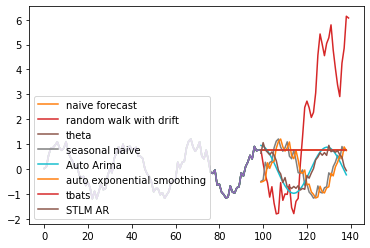

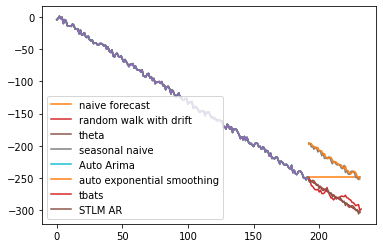

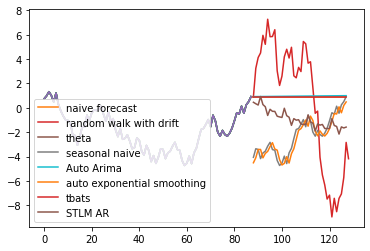

In [ ]:
forecast_horizon = 40
seasonality = 14

examples = [sine_example,linear_example,random_drift_example]

def run_forcast_plotter(run):
  if run:
    for example in examples: 

      forecast_plotter(example,  naive(example, forecast_horizon), "naive forecast")

      forecast_plotter(example,  random_walk_with_drift(example, forecast_horizon), "random walk with drift")

      forecast_plotter(example, theta(example,forecast_horizon), "theta")
      
      forecast_plotter(example, snaive(example,forecast_horizon), "seasonal naive")

      forecast_plotter(example, auto_arima(example,forecast_horizon), "Auto Arima")

      forecast_plotter(example, eps(example,forecast_horizon), "auto exponential smoothing")

      forecast_plotter(example, tbats(example,forecast_horizon), "tbats")

      forecast_plotter(example, stlm_ar(example, 40), "STLM AR")

    

      
      plt.legend(loc="lower left")
      plt.show()
run_forcast_plotter(False)

#Implement all models as part of a emsemble class

In [ ]:
#Returns list of forecast over forcast horizon for all 8 implemented models 
class Ensemble:  
  #list of models 
  #time_series
  #model_fitted
  def _reset_models(self):
    self.models = []

    for key in self.keys:
      self.models.append(self.model_library[key])
    self.forecasts = None
    self.models_fitted = False

  def __init__(self, lst_with_input_strings):
    self.model_library = {"Random_walk_with_drift":Random_walk_with_drift(),"Naive":Naive(), "Snaive":Snaive(), "Tbats":Tbats(), "Theta":Theta(),"Auto_Arima":Auto_Arima(),"Auto_Eps":Eps(),"STLM_AR": STLM_AR()}
    self.keys = lst_with_input_strings

    self._reset_models()

  def fit(self, time_series, seasonality):
    if self.models_fitted == True:
      self._reset_models()
      
    for model in self.models:
      model.fit(time_series, seasonality)
    
    self.time_series = time_series
    self.models_fitted = True

  """Returns a list of forecasts"""
  def forecast(self, forecast_horizon):
    """Returns list of tuples (forecast, forcasting_model_name)"""
    
    if not self.models_fitted:
      raise Exception("Tried forecasting without fitting models") 
    forecasts = []
    for model in self.models:
      forecasts.append( ( model.forecast(forecast_horizon), str(model)))
    self.forecasts = forecasts
    return forecasts 
  
  def plot(self, show_historic_data=False):
    if self.forecasts == None:
      raise Exception("Tried plotting without forecasting")
    
    for forecast in self.forecasts:
      forecast_plotter(self.time_series, forecast[0], forecast[1],show_historic_data)
    plt.legend()
    plt.show()

#Test the ensemble class

In [ ]:
models = ["Random_walk_with_drift","Naive","Snaive", "Tbats", "Theta", "Auto_Arima", "Auto_Eps", "STLM_AR"] 

full_ensemble = Ensemble(models)

time_series1 = sine_example[:-11]
time_series2 = linear_example[:-11]
time_series3 = random_drift_example[:-11]

time_series = [time_series1, time_series2, time_series3]
forecast_horizon = 10
seasonality = 10

def run_ensembles(run):
  if run:
    for time_series in time_series:
      full_ensemble.fit(time_series,  seasonality)
      full_ensemble.forecast(20)
      full_ensemble.plot(True)
run_ensembles(False)

## Save trained models to file

In [ ]:
"""import pandas as pd

df = pd.read_csv("Monthly-train.csv").set_index("V1") 
df.head()     
"""


  

,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,...,V2756,V2757,V2758,V2759,V2760,V2761,V2762,V2763,V2764,V2765,V2766,V2767,V2768,V2769,V2770,V2771,V2772,V2773,V2774,V2775,V2776,V2777,V2778,V2779,V2780,V2781,V2782,V2783,V2784,V2785,V2786,V2787,V2788,V2789,V2790,V2791,V2792,V2793,V2794,V2795
V1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
M1,8000.0,8350.0,8570.0,7700.0,7080.0,6520.0,6070.0,6650.0,6830.0,5710.0,5260.0,5470.0,7870.0,7360.0,8470.0,7880.0,6750.0,6860.0,6220.0,6650.0,5450.0,5280.0,4970.0,5550.0,7750.0,7760.0,7190.0,7440.0,6590.0,6210.0,6010.0,6390.0,5780.0,5700.0,4680.0,4970.0,6850.0,6740.0,7490.0,6250.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
M2,2440.0,2490.0,2710.0,2290.0,1960.0,1990.0,1960.0,2530.0,2640.0,2650.0,2150.0,1910.0,2510.0,2100.0,1840.0,2330.0,1830.0,2290.0,2090.0,2340.0,2420.0,1850.0,1960.0,2000.0,2300.0,2160.0,1730.0,2090.0,1890.0,2180.0,1950.0,2020.0,1770.0,1960.0,1860.0,1340.0,2150.0,2180.0,2030.0,1730.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
M3,2670.0,2590.0,2784.0,2816.0,2888.0,2906.0,2839.0,2860.0,2798.0,2795.0,2796.0,2858.0,2782.0,2801.0,2907.0,2919.0,2937.0,2878.0,2841.0,2967.0,3050.0,2981.0,3076.0,3033.0,2936.0,2927.0,2929.0,2987.0,2777.0,2760.0,2769.0,2830.0,2861.0,2991.0,3063.0,3134.0,3020.0,2947.0,3026.0,3060.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
M4,7264.0,7215.0,7022.0,7040.0,6966.0,6984.0,7025.0,7082.0,6956.0,7014.0,7067.0,7099.0,7046.0,7139.0,7011.0,7022.0,7084.0,7036.0,7098.0,7083.0,7045.0,7057.0,6986.0,6937.0,6927.0,6953.0,7007.0,6949.0,6930.0,6925.0,6956.0,6946.0,6866.0,6814.0,6806.0,6806.0,6855.0,6951.0,6898.0,6898.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
M5,4210.0,4290.0,4250.0,4320.0,4320.0,4330.0,4320.0,4260.0,4220.0,4260.0,4180.0,4230.0,4270.0,4500.0,4410.0,4440.0,4430.0,4440.0,4540.0,4450.0,4420.0,4410.0,4300.0,4300.0,4420.0,4350.0,4340.0,4410.0,4340.0,4400.0,4360.0,4420.0,4470.0,4310.0,4280.0,4220.0,4190.0,4120.0,4150.0,4190.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
"""models = {}
for idx, row in df.iterrows(): 
  ensemble = Ensemble(["Random_walk_with_drift","Naive","Snaive", "Tbats", "Theta", "Auto_Arima", "Auto_Eps", "STLM_AR"] )
  ensemble.fit(row.dropna().to_list(), None)

  models[idx] = ensemble
  break

with open('ensembles.pickle', 'wb') as handle:
    pickle.dump(models, handle, protocol=pickle.HIGHEST_PROTOCOL)
 """

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


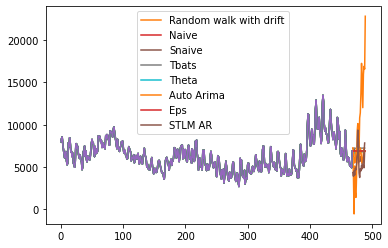

In [ ]:
"""with open('ensembles.pickle', 'rb') as handle:
    b = pickle.load(handle)
b["M1"].forecast(20)
b["M1"].plot(True)"""

##**KLADD: Implement all set of models **

In [ ]:
"""#SETUP tests data
def model_results(x,y):
  models = []
  
  OLS = sm.regression.linear_model.OLS(y,x)
  models.append(OLS)
  
  GLS = sm.regression.linear_model.GLS(y,x)
  models.append(GLS)
  
  quant_reg = sm.QuantReg(y,x)
  models.append(quant_reg)

  ARIMA = sm.tsa.ARIMA(y.to_numpy().reshape((-1,1)), order=(1,0,1)) #ARIMA(x, order=(1,0,0) how to set order?
  models.append(ARIMA)
  
  AARIMA = pm.auto_arima(y) #q = order of moving average p = order of autoregression 
  models.append(AARIMA)
  
  results = []
  for i in range(len(models)):
    #make sure aarima is fitted appropriately 
    if i == len(models)-1:
      print("\t\t  ============== AUTO ARIMA ==============")
      res = models[i].fit(y)
    else:
      res = models[i].fit()
    
    print(res.summary())
    results.append(res)
    
  return results

def main():
  duncan_prestige = sm.datasets.get_rdataset("Duncan", "carData")
  Y = duncan_prestige.data['income']
  X = duncan_prestige.data['education']
  #X = sm.add_constant(X)
  print(X.shape)
  print(Y.shape)
  print(model_results(X,Y))

main()
"""  

(45,)
(45,)
                                 OLS Regression Results                                
Dep. Variable:                 income   R-squared (uncentered):                   0.870
Model:                            OLS   Adj. R-squared (uncentered):              0.867
Method:                 Least Squares   F-statistic:                              294.0
Date:                Wed, 27 Oct 2021   Prob (F-statistic):                    4.24e-21
Time:                        17:07:19   Log-Likelihood:                         -192.50
No. Observations:                  45   AIC:                                      387.0
Df Residuals:                      44   BIC:                                      388.8
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
